# Notebook to open and view detections on audio:

## 1) Figuring out our imports:

### a) Below are the imports pertaining to accessing data and metadata

In [274]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

### b) Below are the imports pertaining to data manipulation

In [275]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

### c) Below are the imports pertaining to data visualization

In [276]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt

In [277]:
import torch
import models.bat_call_detector.batdetect2.bat_detect.utils.detector_utils as du
import models.bat_call_detector.batdetect2.bat_detect.utils.audio_utils as au

import librosa

### d) Below are the imports pertaining to the use of the MSDS pipeline

In [278]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from cfg import get_config

In [279]:
df = pd.read_csv('../output_dir/UBNA_202309/20230915_central_pond/batdetect2_pipeline_UBNA_23-09-15-19_49_24_14.csv')

In [280]:
df

start_time  end_time  low_freq  high_freq                class  \
0        0.1025    0.1123     27187      39456  Eptesicus serotinus   
1        0.2025    0.2146     24609      29917    Nyctalus leisleri   
2        0.2285    0.2381     27187      35706    Nyctalus leisleri   
3        0.3395    0.3497     26328      33312    Nyctalus leisleri   
4        0.3615    0.3712     27187      40878  Eptesicus serotinus   
..          ...       ...       ...        ...                  ...   
223     56.1945   56.2085     23750      31314    Nyctalus leisleri   
224     56.4635   56.4778     23750      30191    Nyctalus leisleri   
225     56.6205   56.6329     24609      30641    Nyctalus leisleri   
226     57.1605   57.1745     23750      30306    Nyctalus leisleri   
227     57.7285   57.7402     24609      30398    Nyctalus leisleri   

     class_prob  det_prob  individual         event  \
0         0.487     0.720          -1  Echolocation   
1         0.453     0.589          -1  Echolocation   
2         0.391     0.704          -1  Echolocation   
3         0.354     0.568          -1  Echolocation   
4         0.446     0.749          -1  Echolocation   
..          ...       ...         ...           ...   
223       0.347     0.652          -1  Echolocation   
224       0.404     0.674          -1  Echolocation   
225       0.389     0.642          -1  Echolocation   
226       0.371     0.639          -1  Echolocation   
227       0.451     0.615          -1  Echolocation   

                                            input_file  
0    /mnt/ubna_data_03/UBNA_202309/20230915_central...  
1    /mnt/ubna_data_03/UBNA_202309/20230915_central...  
2    /mnt/ubna_data_03/UBNA_202309/20230915_central...  
3    /mnt/ubna_data_03/UBNA_202309/20230915_central...  
4    /mnt/ubna_data_03/UBNA_202309/20230915_central...  
..                                                 ...  
223  /mnt/ubna_data_03/UBNA_202309/20230915_central...  
224  /mnt/ubna_data_03/UBNA_202309/20230915_central...  
225  /mnt/ubna_data_03/UBNA_202309/20230915_central...  
226  /mnt/ubna_data_03/UBNA_202309/20230915_central...  
227  /mnt/ubna_data_03/UBNA_202309/20230915_central...  

[228 rows x 10 columns]

In [364]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [ ]:
df = pd.read_csv('../output_dir/recover-20230920/E18 Bridge/bd2__recover-20230920_UBNA_002.csv')

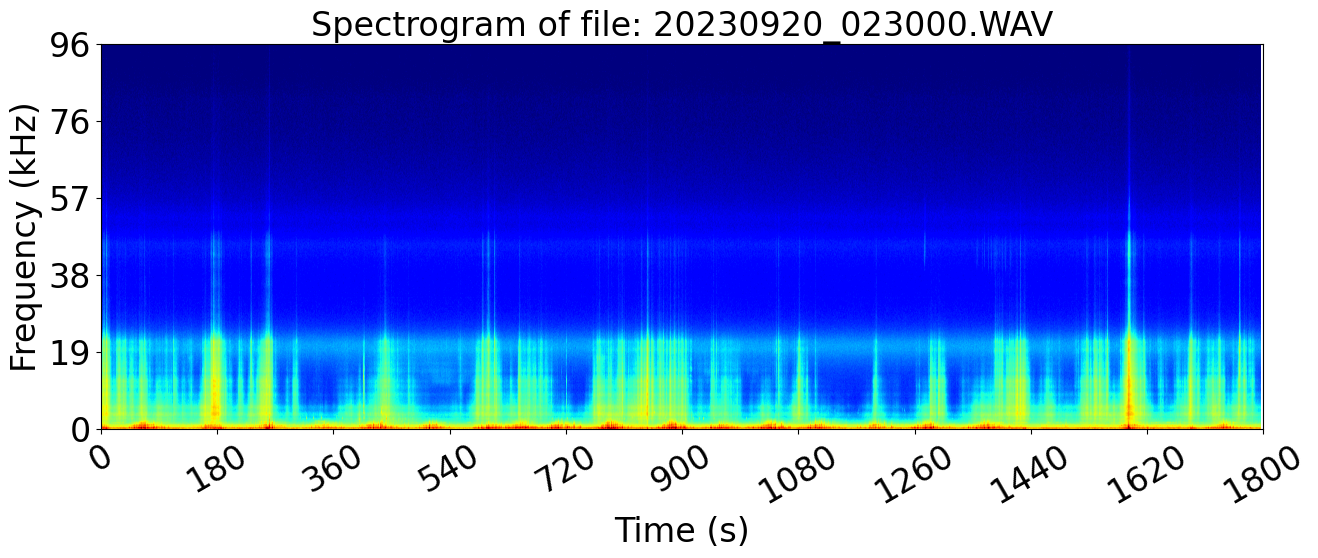

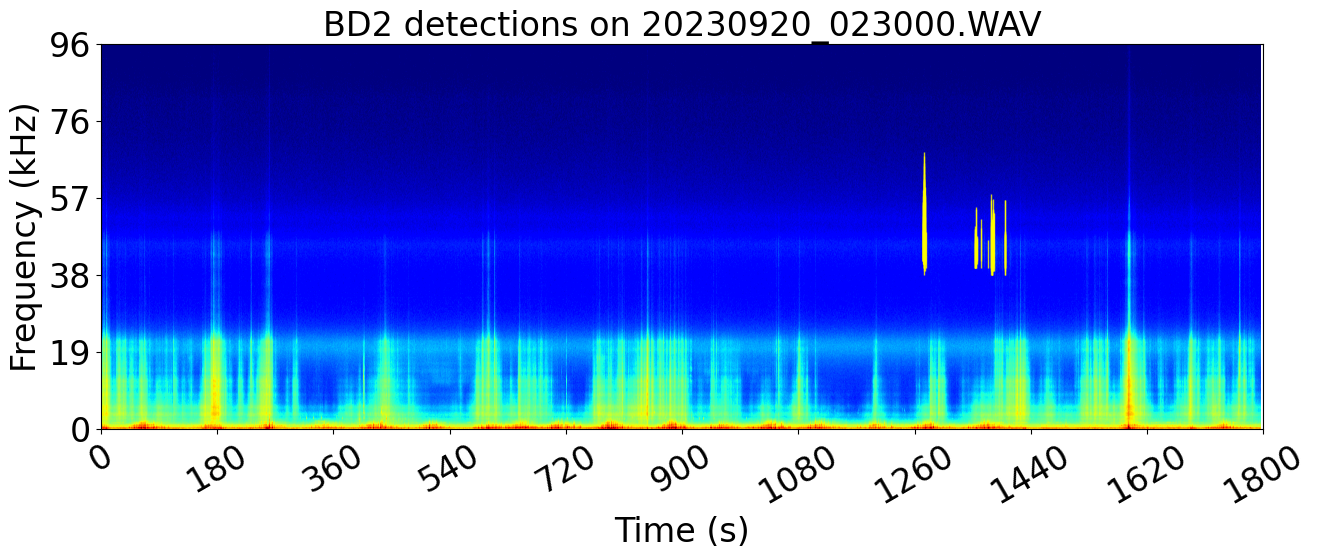

In [371]:
plot_file = Path('../../Downloads/recover-20230920/20230920_023000.WAV')
plot_df = df.loc[pd.to_datetime(df['input_file'], format='%Y%m%d_%H%M%S', exact=False) == dt.datetime.strptime(plot_file.name, '%Y%m%d_%H%M%S.WAV')]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"
plot_audio_seg(audio_features, spec_features)
spec_features['plot_title'] = f"BD2 detections on {audio_features['file_path'].name}"
plot_dets_over_audio(audio_features, spec_features, plot_df)

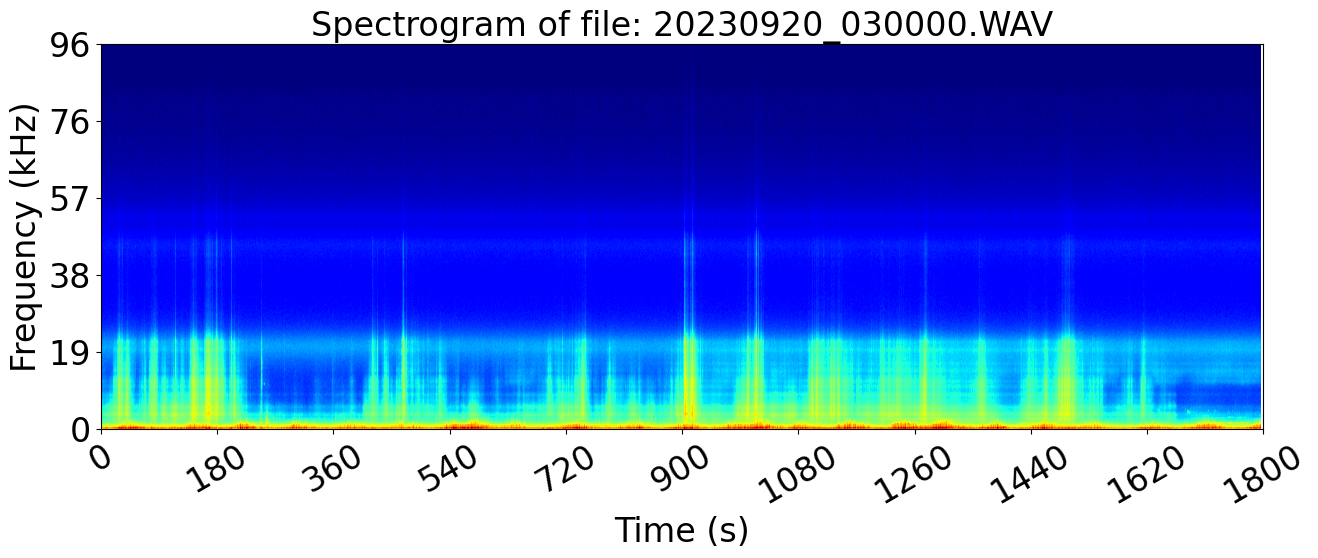

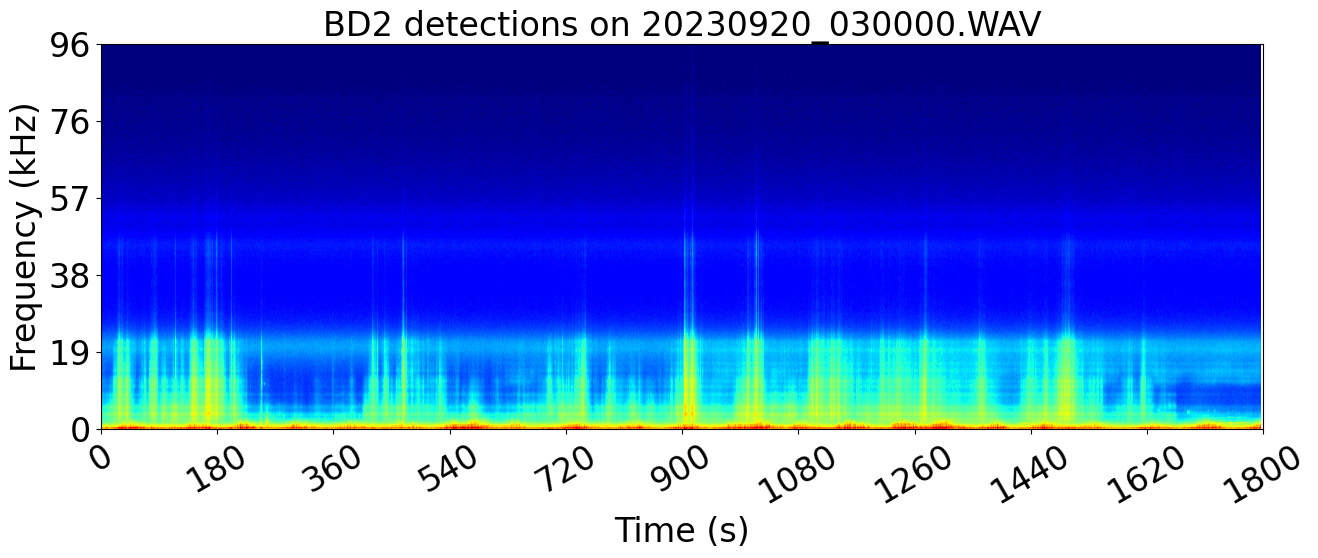

In [372]:
plot_file = Path('../../Downloads/recover-20230920/20230920_030000.WAV')
plot_df = df.loc[pd.to_datetime(df['input_file'], format='%Y%m%d_%H%M%S', exact=False) == dt.datetime.strptime(plot_file.name, '%Y%m%d_%H%M%S.WAV')]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"
plot_audio_seg(audio_features, spec_features)
spec_features['plot_title'] = f"BD2 detections on {audio_features['file_path'].name}"
plot_dets_over_audio(audio_features, spec_features, plot_df)

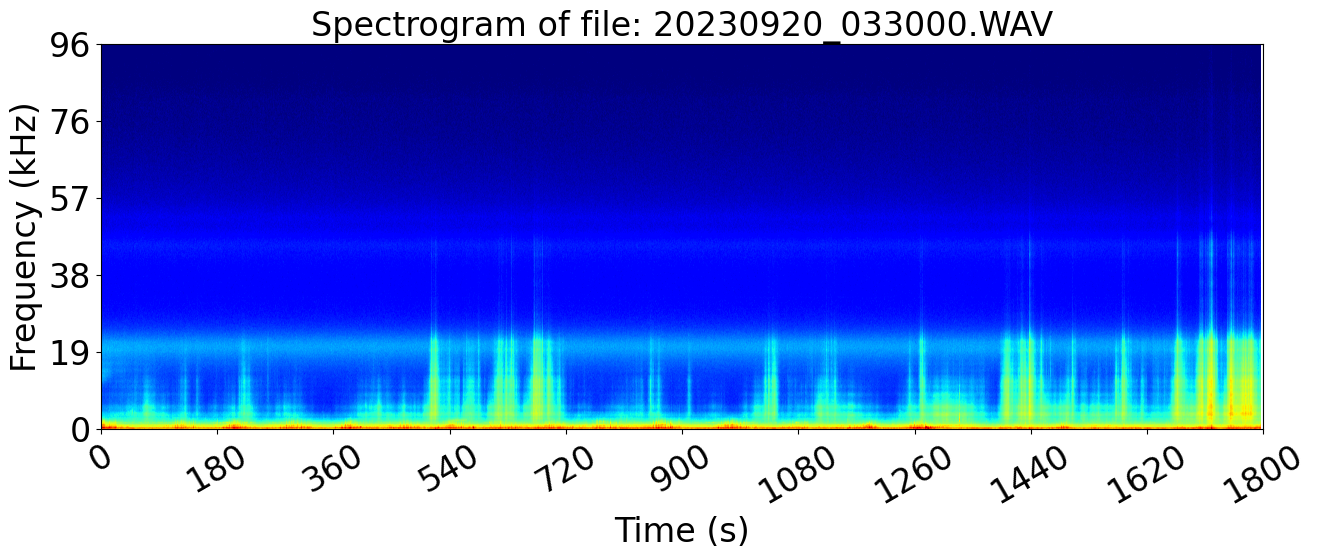

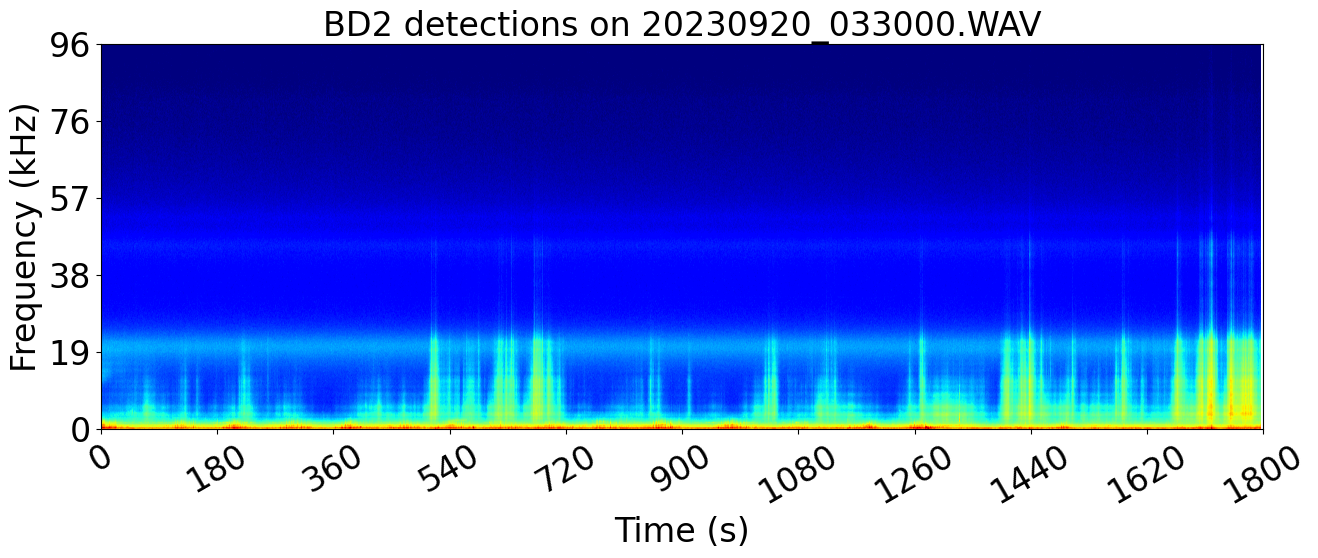

In [373]:
plot_file = Path('../../Downloads/recover-20230920/20230920_033000.WAV')
plot_df = df.loc[pd.to_datetime(df['input_file'], format='%Y%m%d_%H%M%S', exact=False) == dt.datetime.strptime(plot_file.name, '%Y%m%d_%H%M%S.WAV')]
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + 0
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"
plot_audio_seg(audio_features, spec_features)
spec_features['plot_title'] = f"BD2 detections on {audio_features['file_path'].name}"
plot_dets_over_audio(audio_features, spec_features, plot_df)

In [18]:
input_file = Path('/Volumes/Elements/recover-20220815/central_pond/20220813_070000.WAV')

cfg = get_config()
cfg['input_audio'] = input_file
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = False
cfg['save'] = True

batdetect2_pipeline.run_pipeline_on_file(input_file, cfg)

100%|██████████| 60/60 [08:13<00:00,  8.22s/it]


start_time   end_time  low_freq  high_freq                  class  \
0       3.0445     3.0595   23750.0    28084.0      Nyctalus leisleri   
1      14.8625    14.8741   23750.0    30718.0    Eptesicus serotinus   
2      16.5085    16.5220   23750.0    29404.0      Nyctalus leisleri   
3      16.9985    17.0102   23750.0    30844.0    Eptesicus serotinus   
4      17.5375    17.5501   22890.0    29133.0      Nyctalus leisleri   
..         ...        ...       ...        ...                    ...   
0    1793.8505  1793.8604   40937.0    49374.0  Pipistrellus nathusii   
1    1794.2215  1794.2296   40937.0    50497.0  Pipistrellus nathusii   
2    1794.4015  1794.4110   40078.0    51029.0  Pipistrellus nathusii   
3    1794.6825  1794.6913   40937.0    51857.0  Pipistrellus nathusii   
4    1794.9515  1794.9598   40078.0    52981.0  Pipistrellus nathusii   

    class_prob  det_prob individual         event  \
0        0.450     0.581         -1  Echolocation   
1        0.277     0.631         -1  Echolocation   
2        0.344     0.609         -1  Echolocation   
3        0.277     0.583         -1  Echolocation   
4        0.269     0.644         -1  Echolocation   
..         ...       ...        ...           ...   
0        0.430     0.507         -1  Echolocation   
1        0.484     0.550         -1  Echolocation   
2        0.444     0.577         -1  Echolocation   
3        0.479     0.559         -1  Echolocation   
4        0.433     0.520         -1  Echolocation   

                                           input_file  
0   /Volumes/Elements/recover-20220815/central_pon...  
1   /Volumes/Elements/recover-20220815/central_pon...  
2   /Volumes/Elements/recover-20220815/central_pon...  
3   /Volumes/Elements/recover-20220815/central_pon...  
4   /Volumes/Elements/recover-20220815/central_pon...  
..                                                ...  
0   /Volumes/Elements/recover-20220815/central_pon...  
1   /Volumes/Elements/recover-20220815/central_pon...  
2   /Volumes/Elements/recover-20220815/central_pon...  
3   /Volumes/Elements/recover-20220815/central_pon...  
4   /Volumes/Elements/recover-20220815/central_pon...  

[1201 rows x 10 columns]

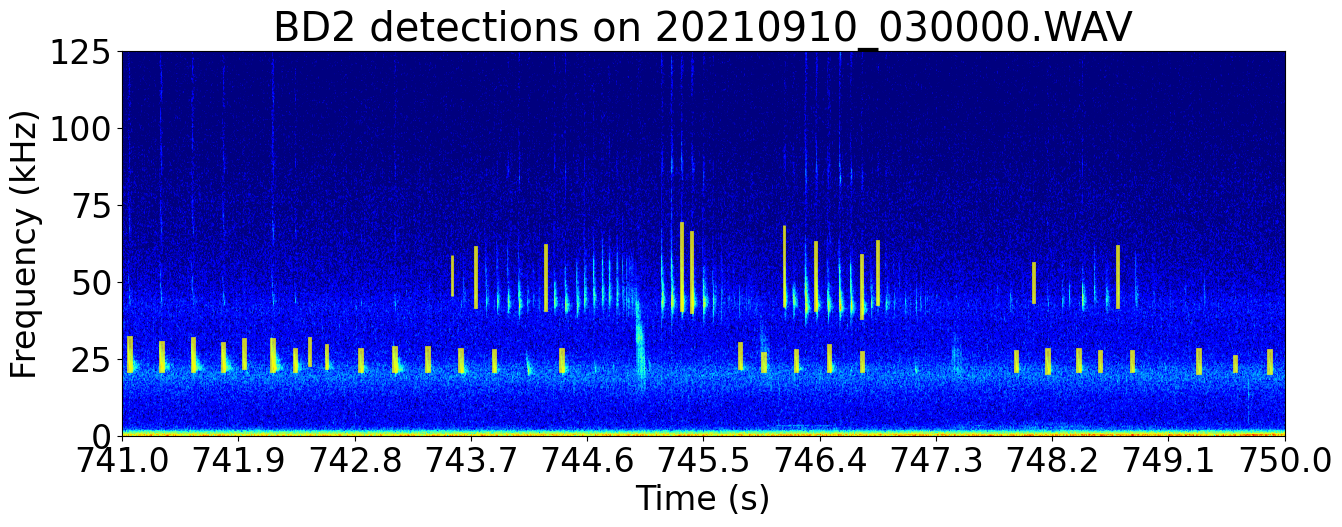

100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


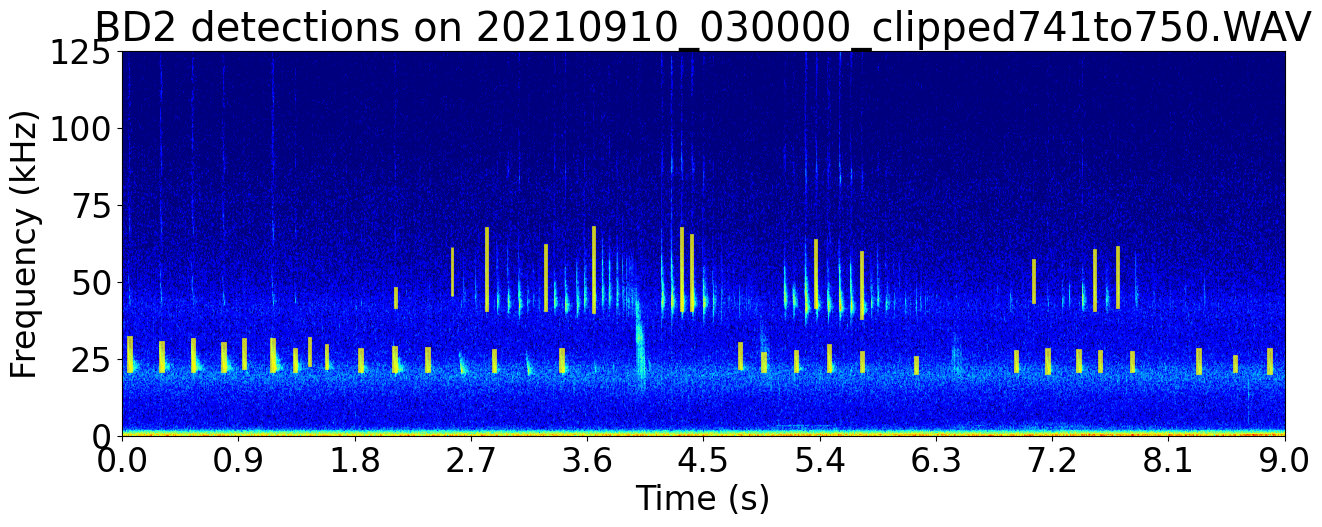

In [13]:
input_file = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file)
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file.name.split('.')[0]
original_file_dets = pd.read_csv(f'../output_dir/batdetect2_pipeline_{filename}.csv')

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 741
duration = 9
end = int(start+duration)
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 50 # hide anything below -rm_dB dB
write_file = f'../../Downloads/{filename}_clipped{start}to{end}.WAV'

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+duration))
original_plot_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, original_plot_dets)
sf.write(write_file, audio_seg, fs)

input_file = Path(write_file)

cfg = get_config()
cfg['input_audio'] = input_file
cfg['tmp_dir'] = Path('../output')
cfg['output_dir'] = Path('../output_dir')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

clipped_file_dets = batdetect2_pipeline.run_pipeline_on_file(input_file, cfg)

audio_file = sf.SoundFile(input_file)
fs = audio_file.samplerate
start = 0
audio_seg = audio_file.read()

audio_features = dict()
audio_features['file_path'] = input_file
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin

window_cond = np.logical_and(clipped_file_dets['start_time'] > start, clipped_file_dets['end_time'] < (start+duration))
clipped_plot_dets = clipped_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, clipped_plot_dets)

clipped_plot_dets['start_time'] = 646+clipped_plot_dets['start_time']
clipped_plot_dets['end_time'] = 646+clipped_plot_dets['end_time']